In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [2]:
!nvidia-smi

Thu Mar  4 00:12:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 22%   24C    P8    20W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 24%   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6"  # don’t use 0 for Hub

In [4]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, measure
from scipy import ndimage, misc

In [5]:
subset = np.load("lessimgs2.npy")
subset = subset[:, :, :, 0, :, : , :, :, :]

y = np.zeros(subset.shape[:-2], dtype=int)
for i in range(5):
    y[i] = i
    
x = subset.reshape(-1, subset.shape[-4], subset.shape[-3], subset.shape[-2], subset.shape[-1])
y = y.reshape(-1, subset.shape[-4], subset.shape[-3])

# shuffle

np.random.seed(0)
index = np.arange(np.cumprod(subset.shape)[3])
np.random.shuffle(index)

x = x[index]
y = y[index]

x = x.reshape(-1, 64, 64)
y = y.reshape(-1)

xprime = np.zeros_like(x)

In [6]:

for i in range(x.shape[0]):
    xnew = x[i]  + 0.1*np.std(x[i])* np.random.random( (64, 64) )
    xnew = (np.log10(xnew) - np.log10(xnew.max()) + 2.) / 2.
    xprime[i] = xnew 
xprime[xprime < 0] = 0

x = xprime

# 0.6: 0.2: 0.2
x_train = x[:int(x.shape[0]*0.6)]
y_train = y[:int(x.shape[0]*0.6)]

x_val = x[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]
y_val = y[int(x.shape[0]*0.6):int(x.shape[0]*0.8)]

x_test  = x[int(x.shape[0]*0.8):]
y_test  = y[int(x.shape[0]*0.8):]

index = np.arange(y_train.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]


index = np.arange(y_val.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

index = np.arange(y_test.shape[0])
np.random.seed(0)
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [7]:
x_train = x_train[:,:,:,None]
x_val = x_val[:,:,:,None]
x_test = x_test[:,:,:,None]

In [8]:
# Training parameters
BATCH_SIZE = 128  # orig paper trained all networks with batch_size=128
EPOCHS = 100 # 200
USE_AUGMENTATION = False
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

# Model version
# Orig paper: version = 1 (ResNet v1), 
# Improved ResNet: version = 2 
# (ResNet v2)
VERSION = 2

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = 2*COLORS * 6 + 2
    #DEPTH = COLORS * 6 + 2
elif VERSION == 2:
    DEPTH = 2*COLORS * 9 + 2

In [9]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [10]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [11]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 5e-4
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [13]:
def decayed_learning_rate(step):
  step = min(step, decay_steps)
  cosine_decay = 0.5 * (1 + cos(pi * step / decay_steps))
  decayed = (1 - alpha) * cosine_decay + alpha
  return initial_learning_rate * decayed

In [14]:
tf.keras.experimental.CosineDecay?

In [15]:
decay_steps = 100
initial_learning_rate = 5e-3
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate, decay_steps)

In [16]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [17]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is 
    halved (downsampled) by a convolutional layer with 
    strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same
    number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:
NUM_CLASSES

5

In [16]:
SUBTRACT_PIXEL_MEAN = False

In [ ]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tensorflow.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

# Create the neural network
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH, num_classes=5)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH, num_classes=5)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()


In [17]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
#lr_scheduler = LearningRateScheduler(lr_schedule)
lr_scheduler = LearningRateScheduler(lr_decayed_fn)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_scheduler]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_val, y_val),
              shuffle=False,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, 
                        batch_size=BATCH_SIZE),
                        validation_data=(x_test, y_test),
                        epochs=EPOCHS, verbose=0, workers=1,
                        callbacks=callbacks, 
                        use_multiprocessing=False)
    
elapsed_time = time.time() - start_time
#print("Elapsed time: {}".format(hms_string(elapsed_time)))

Not using data augmentation.
Train on 103680 samples, validate on 34560 samples
Epoch 1/100
103680/103680 [==============================] - 74s 710us/sample - loss: 0.9674 - accuracy: 0.6631 - val_loss: 1.0812 - val_accuracy: 0.5847
Epoch 2/100
103680/103680 [==============================] - 67s 645us/sample - loss: 0.6308 - accuracy: 0.7966 - val_loss: 0.7479 - val_accuracy: 0.7404
Epoch 3/100
103680/103680 [==============================] - 67s 649us/sample - loss: 0.5586 - accuracy: 0.8299 - val_loss: 0.8411 - val_accuracy: 0.7067
Epoch 4/100
103680/103680 [==============================] - 67s 645us/sample - loss: 0.5080 - accuracy: 0.8527 - val_loss: 0.7592 - val_accuracy: 0.7494
Epoch 5/100
103680/103680 [==============================] - 66s 639us/sample - loss: 0.4755 - accuracy: 0.8683 - val_loss: 0.6817 - val_accuracy: 0.7982
Epoch 6/100
103680/103680 [==============================] - 67s 642us/sample - loss: 0.4474 - accuracy: 0.8808 - val_loss: 0.7167 - val_accuracy: 0.7

In [7]:
!conda install -c anaconda pydot 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/shjzhang/miniconda3

  added / updated specs:
    - pydot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         128 KB  anaconda
    certifi-2020.6.20          |           py37_0         159 KB  anaconda
    conda-4.9.0                |           py37_0         3.1 MB  anaconda
    fribidi-1.0.10             |       h7b6447c_0         115 KB  anaconda
    graphviz-2.40.1            |       h21bd1

In [ ]:
conda install -c anaconda graphviz 

In [18]:
model.save("model_oct24_resnet/model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_oct24_resnet/model/assets


In [5]:
model = tf.keras.models.load_model("model_oct24_resnet/model")

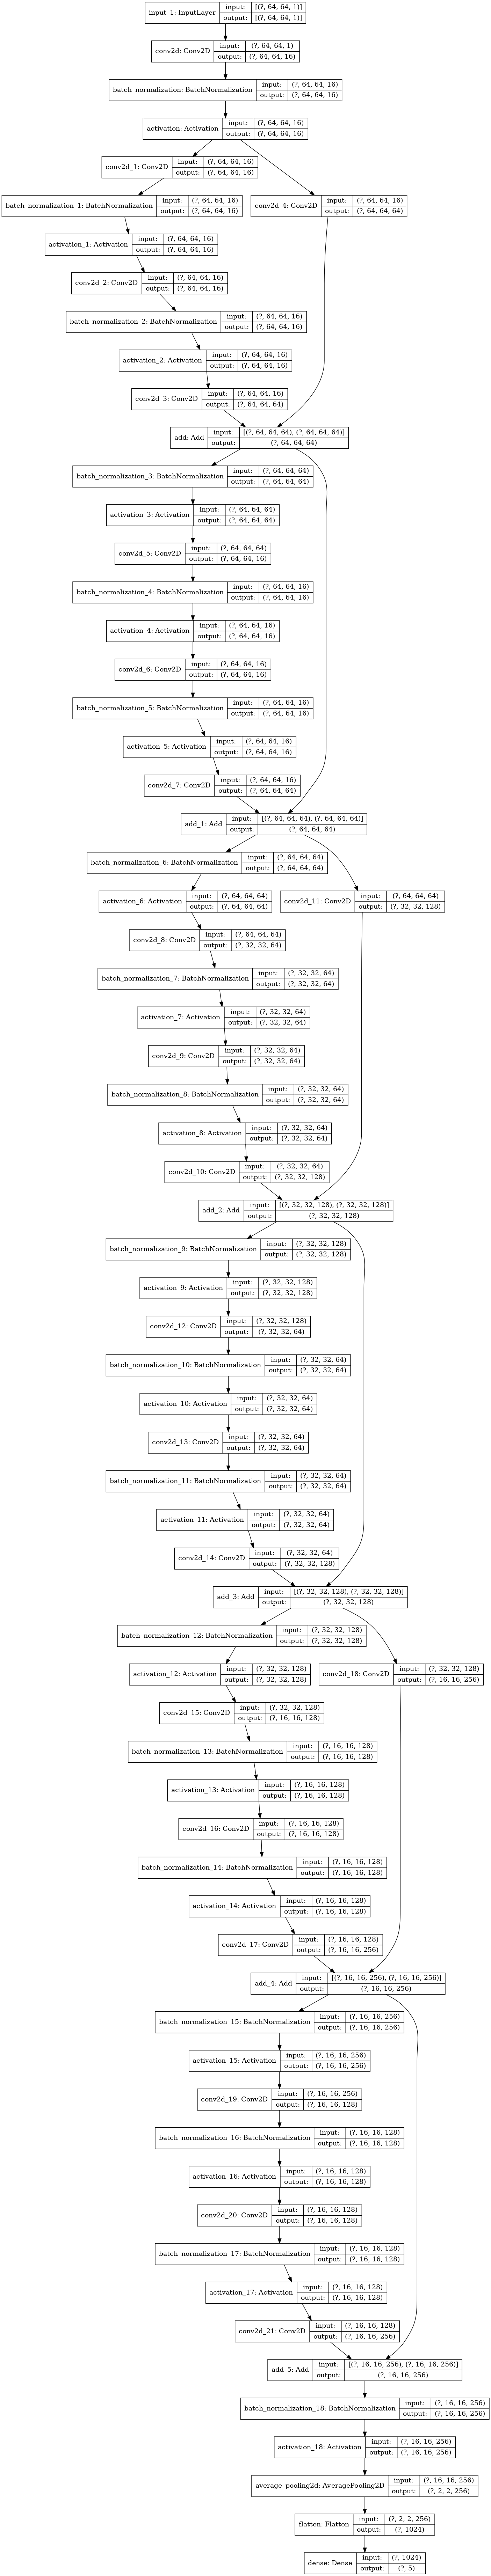

In [6]:
tf.keras.utils.plot_model(model, to_file="test_modelplot.png", show_shapes=True)

In [21]:
x_test[None,301,:,:].shape

(1, 64, 64, 1)

In [20]:
x_test.shape

(34560, 64, 64, 1)

In [24]:
prediction_score = model.predict(x_test[:,:,:])

In [28]:
prediction_class = np.argmax(prediction_score, axis=1)

In [31]:
y_test = np.argmax(y_test, axis=1)

NameError: name 't_test' is not defined

([<matplotlib.axis.YTick at 0x7f0b2c4c96d0>,
 <a list of 5 Text yticklabel objects>)

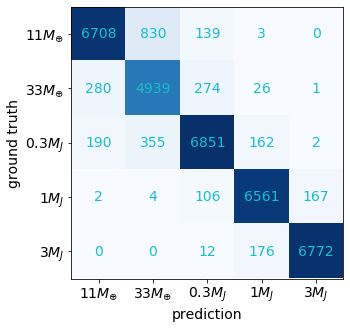

In [32]:
y_predict = prediction_class
#y_test = np.argmax(y_test, axis=1)
confusion_mat = np.zeros((5,5), dtype='int')
for i in range(5):
    for j in range(5):
        confusion_mat[i][j] = np.sum((y_test == i) & (y_predict == j))
        
plt.rc("font", size=14)
plt.figure(figsize=(7.5,5))
plt.imshow(confusion_mat, cmap='Blues')
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(confusion_mat[i][j]), color = 'C9',
                 horizontalalignment='center', verticalalignment='center')
plt.xlabel("prediction")
plt.ylabel("ground truth")
plt.xticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])
plt.yticks(np.arange(5), [r"11$M_{\oplus}$", r"33$M_{\oplus}$", r"0.3$M_J$", r"1$M_J$",  r"3$M_J$"])

In [22]:
np.argmax(model.predict(x_test[:,:,:]), axis=)

19

In [36]:
np.argmax?

In [35]:
np.argmax(model.predict(x_test[None,:,:,:])

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (1, 34560, 64, 64, 1)

In [ ]:
model.predict(x_test[None,10000,:,:])

In [20]:
loss, accuracy_test = model.evaluate(x_test,  y_test, verbose=2)

34560/34560 - 13s - loss: 0.5758 - accuracy: 0.9210


In [58]:
np.arange(0,12096)
np.arange(12096,12096+36288)
np.arange(12096+36288,12096+36288+12096)

array([48384, 48385, 48386, ..., 60477, 60478, 60479])

In [59]:
# 0.6: 0.2: 0.2
x_train = x[np.arange(12096,12096+36288)]
y_train = y[np.arange(12096,12096+36288)]

x_val = x[np.arange(12096+36288,12096+36288+12096)]
y_val = y[np.arange(12096+36288,12096+36288+12096)]

x_test  = x[np.arange(0,12096)]
y_test  = y[np.arange(0,12096)]

In [8]:
model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=( 64, 64, 1)),
          tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          #tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
          #tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
          #tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(5)
        ])

In [9]:
%load_ext tensorboard
import tensorflow as tf
import datetime

!rm -rf ./logs/ 


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [62]:
img_size = (64, 64)

last_conv_layer_name = "add_5"
classifier_layer_names = [
    
    "batch_normalization_18",
    "activation_18",
    "average_pooling2d",
    "flatten",
    "dense"
]

from tensorflow import keras
import matplotlib.cm as cm

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



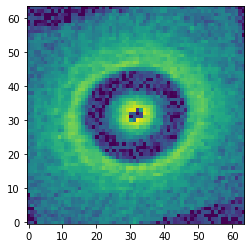

In [38]:
plt.imshow(x[0,:,:], origin="lower")

In [59]:
img_array.shape

(1, 64, 64, 1)

In [61]:
classifier_layer_names

['add_5',
 'batch_normalization_18',
 'activation_18',
 'average_pooling2d',
 'flatten',
 'dense']

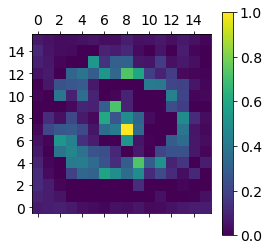

In [72]:
# Generate class activation heatmap
img_array = subset[None, 4, 0, 1, 11, 2, 9, :, :, None]
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap, origin='lower')
plt.colorbar()
plt.show()

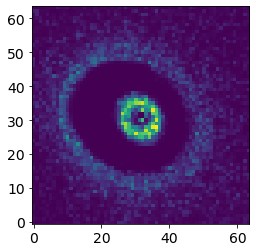

In [73]:
plt.imshow(img_array[0, :,:,0], origin="lower")

In [ ]:
# Follow too much on the ring instead of the gap...

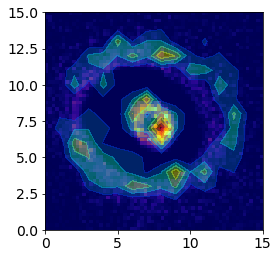

In [74]:
plt.contourf(heatmap, alpha=0.4, cmap='jet')
#plt.contourf(x[8], extent=(0,10,0,10))
plt.imshow(img_array[0, :,:,0],  extent=(0,15,0,15), origin='lower', cmap='inferno')

In [ ]:
0.9520 0.956, 0.9550, 0.9571

In [ ]:
# 85% accuracy

In [46]:
history.history

{'loss': [0.9098645444479779,
  0.4811548566481844,
  0.36410202377687684,
  0.31761732623900896,
  0.26583536881197906,
  0.22864882322110405,
  0.20448362509304463,
  0.17338305267602258,
  0.1415990431393896,
  0.12051051447736313,
  0.10022930630090165,
  0.10576096588394208,
  0.08026488695944113,
  0.07088539154454408,
  0.07375776530547327,
  0.06042526226418464,
  0.06179379681338814,
  0.04928304721655511,
  0.053209557645581336,
  0.04088998448212074],
 'accuracy': [0.5930886,
  0.78629297,
  0.8404982,
  0.8622961,
  0.88351524,
  0.9010141,
  0.9149581,
  0.9301146,
  0.94436175,
  0.9512787,
  0.9621638,
  0.95929784,
  0.96982473,
  0.97415125,
  0.9734623,
  0.9777337,
  0.9772101,
  0.98261136,
  0.98098546,
  0.9850915],
 'val_loss': [0.5750572126378458,
  0.3414277975206022,
  0.3938932092416854,
  0.26930529068386744,
  0.2656095655506881,
  0.2598975769111088,
  0.2106914375194166,
  0.20151781964869725,
  0.1714438636782308,
  0.15112049073453934,
  0.1564575190108

In [45]:
history.history['accuracy']

[0.5930886,
 0.78629297,
 0.8404982,
 0.8622961,
 0.88351524,
 0.9010141,
 0.9149581,
 0.9301146,
 0.94436175,
 0.9512787,
 0.9621638,
 0.95929784,
 0.96982473,
 0.97415125,
 0.9734623,
 0.9777337,
 0.9772101,
 0.98261136,
 0.98098546,
 0.9850915]

[0.76223546,
 0.8472222,
 0.8337467,
 0.8768188,
 0.8776455,
 0.88285387,
 0.9092262,
 0.91906416,
 0.92757934,
 0.93824404,
 0.93791336,
 0.9489914,
 0.9470073,
 0.95155424,
 0.95477843,
 0.95213294,
 0.95147157,
 0.9490741,
 0.9429563,
 0.9522156]

In [33]:
GW_Lup = np.load("AS_209.npy")
model.predict(GW_Lup[None,:,:,None])
# 0.3 M_J
# 0.3 M_J/M_star Best model

array([[0.0000000e+00, 0.0000000e+00, 1.6588686e-04, 9.9983406e-01,
        0.0000000e+00]], dtype=float32)

In [29]:
0.02 / 0.83 * 318

7.662650602409639

In [35]:
GW_Lup = np.load("Elias_24.npy")
model.predict(GW_Lup[None,:,:,None])
# 30 Earth # might be overpredict
# 8 M_E/M_star Best model

array([[0.000000e+00, 7.435160e-36, 9.999976e-01, 2.436827e-06,
        0.000000e+00]], dtype=float32)

In [34]:
GW_Lup = np.load("Sz_114.npy")
model.predict(GW_Lup[None,:,:,None])
# 30 Earth # might be overpredict
# 8 M_E/M_star Best model

array([[1.5842729e-10, 1.0000000e+00, 1.8977193e-09, 1.3998250e-27,
        0.0000000e+00]], dtype=float32)

In [12]:
import pydot

ModuleNotFoundError: No module named 'pydot'

In [11]:
tf.keras.utils.plot_model(
    model, to_file='model210304.png',
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
